In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math

# Загружаем sar_3.jpg
source_image = cv2.imread('sar_3.jpg')
if source_image is None:
    print("ОШИБКА: sar_3.jpg не найден!")
else:
    gray_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)

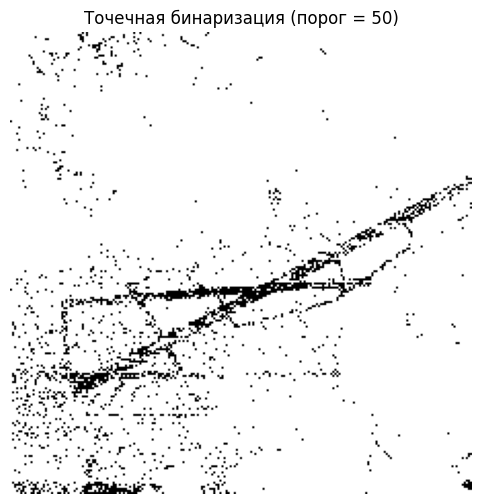

In [2]:
# Точечная бинаризация
bin_img = copy.deepcopy(gray_image)
T = 50
bin_img[gray_image < T] = 0
bin_img[gray_image >= T] = 255

plt.figure(figsize=(8,6))
plt.imshow(bin_img, cmap='gray')
plt.title(f'Точечная бинаризация (порог = {T})')
plt.axis('off')
plt.show()

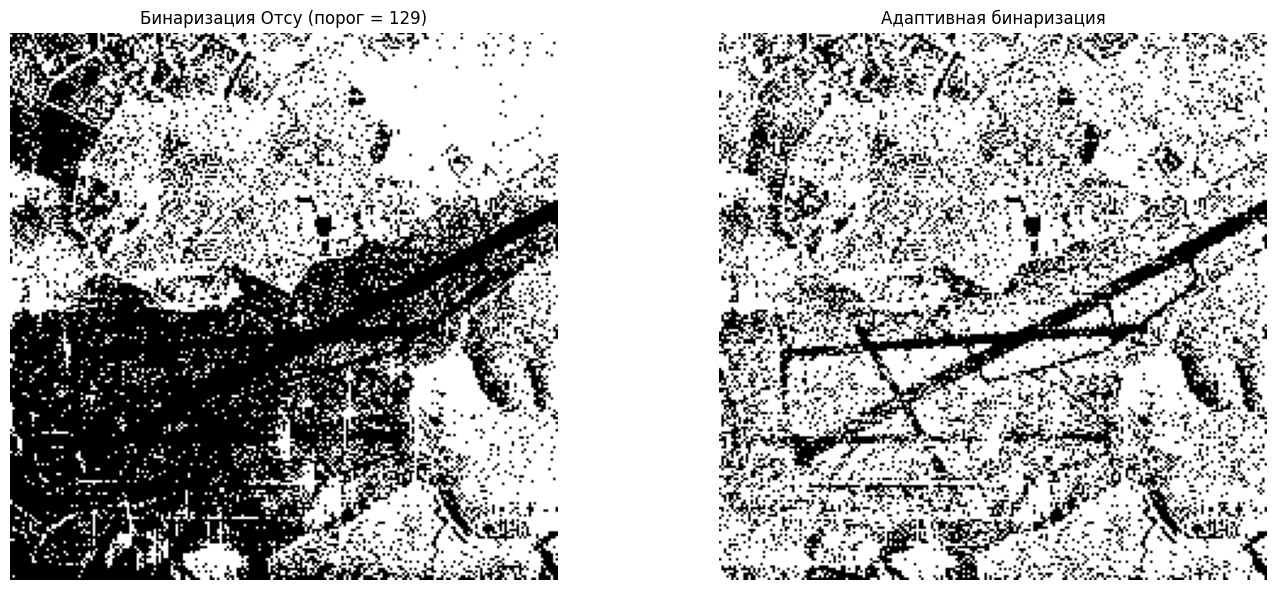

In [3]:
# Бинаризация Оцу
_, binary_otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Адаптивная
adaptive_binary_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv2.THRESH_BINARY, 71, 21)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(binary_otsu_thresh, cmap='gray')
plt.title(f'Бинаризация Отсу (порог = {_:.0f})')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adaptive_binary_thresh, cmap='gray')
plt.title('Адаптивная бинаризация')
plt.axis('off')
plt.tight_layout()
plt.show()

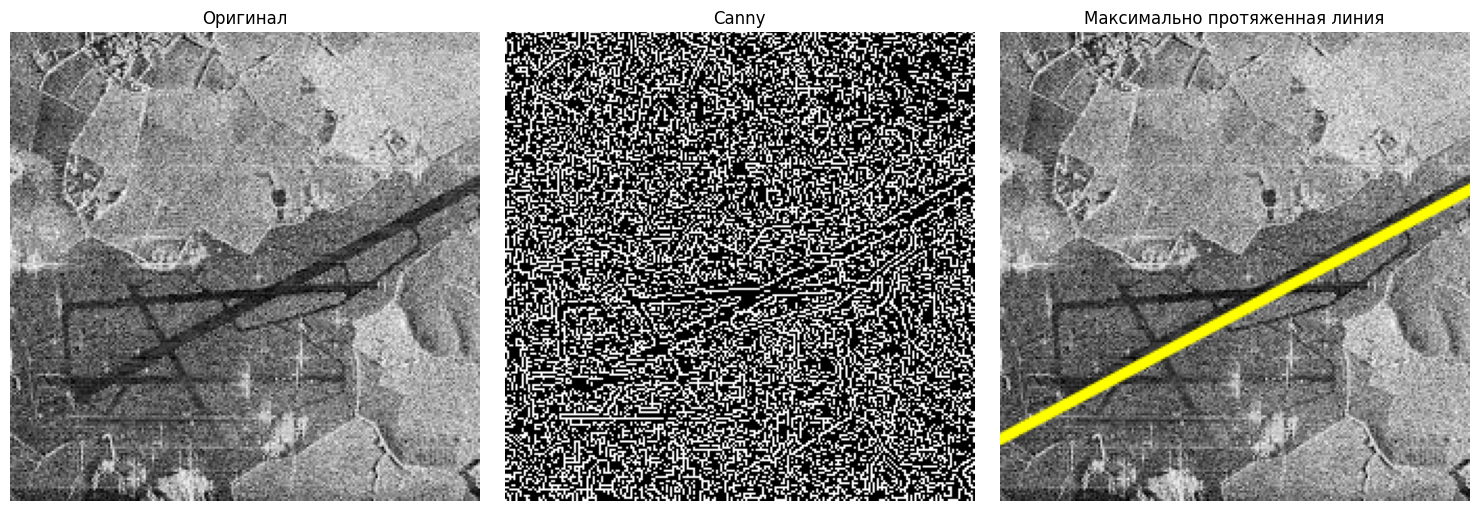

In [4]:
# Canny
edges = cv2.Canny(gray_image, 100, 150, apertureSize=3)

# Хаф
lines = cv2.HoughLines(edges, 1, np.pi / 180, 135)

max_length = 0
longest_line = None
longest_line_image = source_image.copy()

if lines is not None:
    for line in lines:
        r, t = line[0]
        a = np.cos(t)
        b = np.sin(t)
        x0 = a * r
        y0 = b * r
        
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        
        length = np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)
        if length > max_length:
            max_length = length
            longest_line = (pt1, pt2)

    if longest_line is not None:
        cv2.line(longest_line_image, longest_line[0], longest_line[1], (0, 255, 255), 3, cv2.LINE_AA)  # жёлтый

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Оригинал')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(edges, cmap='gray')
plt.title('Canny')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(longest_line_image, cv2.COLOR_BGR2RGB))
plt.title('Максимально протяженная линия')
plt.axis('off')

plt.tight_layout()
plt.show()

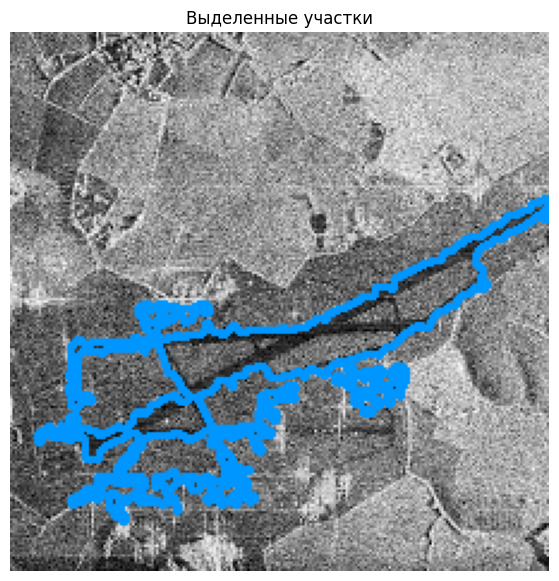

In [5]:
# Адаптивная + морфология
blurred = cv2.GaussianBlur(adaptive_binary_thresh, (7, 7), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

road_detected_image = source_image.copy()
if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 600:
            cv2.drawContours(road_detected_image, [contour], -1, (255, 150, 0), 2)

plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(road_detected_image, cv2.COLOR_BGR2RGB))
plt.title('Выделенные участки')
plt.axis('off')
plt.show()